# CMIP6 Landmask SFTLF

**Following steps are included in this script:**

1. Load netCDF files
2. Create landmask with grid cells including more than 50% land 
3. Save as netcdf files

In [1]:
# ========== Packages ==========
import xarray as xr
import dask
import os
from dask.delayed import delayed

### Functions

In [2]:
def save_file(save_file, variable, folder, save_var=True):
    """
    Save files as netCDF.

    Args:
        savefile (dict or dataset): Dictionary of xarray datasets or dataset.
        folder (string): Name of folder data is saved in.
        save_var (boolean): If True, data is saved separately for each variable. If false, one file is saved with all variables.
        

    Returns:
        nc_out: Path were data is saved in.
    """
    
    if save_var:
        for key, ds_in in save_file.items():
            # Variable to keep
            variable_to_keep = variable
            dimensions_to_keep = {'time', 'lat', 'lon'}
            coordinates_to_keep = {'time', 'lat', 'lon'}

            if any('depth' in ds_in[var].dims for var in ds_in.variables):
                dimensions_to_keep.add('depth')
                coordinates_to_keep.add('depth')

            # The rest of the function remains the same

            # Create a new dataset with only the desired variable
            ds_var = ds_in[[variable_to_keep]]

            # Keep only the desired dimensions
            ds_var = ds_var.isel({dim: slice(None) for dim in dimensions_to_keep.intersection(ds_var.dims)})

            # Set the desired coordinates
            coords_to_set = set(ds_var.variables).intersection(coordinates_to_keep)
            ds_var = ds_var.set_coords(list(coords_to_set))

            savepath = f'../../data/CMIP6/{ds_var.experiment_id}/{folder}/{var}/'
            filename = f'CMIP.{ds_var.source_id}.{ds_var.experiment_id}.{var}.nc'
            nc_out = os.path.join(savepath, filename)
            os.makedirs(savepath, exist_ok=True) 
            if os.path.exists(nc_out):
                   # inp = input(f"Delete old file {filename} (y/n):")
                   # if inp.lower() in ["y"]:
                        os.remove(nc_out)
                        print(f"File  with path: {nc_out} removed")
                   # else:
                   #     filename = "temp_file.nc"
                   #     nc_out = os.path.join(savepath, filename)
                   #     print(f"Filename change to {filename}")

            # Save to netcdf file
            with dask.config.set(scheduler='threads'):
                ds_var.to_netcdf(nc_out)
                print(f"File with path: {nc_out} saved")

    else:
        for key in save_file.keys():
            ds_in = save_file[key]
            filename = f'CMIP.{ds_in.source_id}.{ds_in.experiment_id}.nc'
            savepath = f'../data/CMIP6/{ds_in.experiment_id}/{folder}'
            nc_out = os.path.join(savepath, filename)
            os.makedirs(savepath, exist_ok=True) 
            if os.path.exists(nc_out):
                inp = input(f"Delete old file {filename} (y/n):")
                if inp.lower() in ["y"]:
                    os.remove(nc_out)
                    print(f"File  with path: {nc_out} removed")
                else:
                    filename = "temp_file.nc"
                    nc_out = os.path.join(savepath, filename)
                    print(f"Filename change to {filename}")

            # Save to netcdf file
            with dask.config.set(scheduler='threads'):
                ds_in.to_netcdf(nc_out)

    return nc_out

In [3]:
def find_first_datapoint(ds_dict, variable):
    
    data = ds_dict[list(ds_dict.keys())[0]][variable]

    # Find the first time index with non-NaN values
    non_nan_time_index = data.notnull().any(dim=["lat", "lon"]).argmax().values

    # Find the first time index with non-zero values
    non_zero_time_index = (data != 0).any(dim=["lat", "lon"]).argmax().values

    # Find the maximum of both time indices to get the first time index with actual values
    first_actual_values_time_index = max(non_nan_time_index, non_zero_time_index)

    first_actual_values_time = data.time.isel(time=first_actual_values_time_index).values

    print("First time index with actual values:", first_actual_values_time_index)
    print("First time with actual values:", first_actual_values_time)

In [4]:
def def_landmask(ds_dict):
    
    ### Time coordinates and grid must be equal###
    
    # use lai as land variable to create landmask (check before if reference dataset has values at all land points)
    landmask = (ds_dict[list(ds_dict.keys())[0]]['lai']).astype(int)
    
    # print unique values
    print(f"Unique values:", np.unique(landmask.isel(time=0).values))
    
    # set all numbers below or equal to zero to nan
    landmask = landmask.where(landmask >= 0)
    
    # set all numbers above zero to 1
    landmask = landmask.where(landmask.isnull(), 1)
    
    # save landmask
    filename = f'CMIP.{ds_dict[list(ds_dict.keys())[0]].experiment_id}.landmask_{ds_dict[list(ds_dict.keys())[0]].source_id}.nc'
    savepath = f'../../data/CMIP6/{ds_dict[list(ds_dict.keys())[0]].experiment_id}/landmask/'
    nc_out = os.path.join(savepath, filename)
    os.makedirs(savepath, exist_ok=True) 
    if os.path.exists(nc_out):
        inp = input(f"Delete old file {filename} (y/n):")
        if inp.lower() in ["y"]:
            os.remove(nc_out)
            print(f"File  with path: {nc_out} removed")
        else:
            filename = "temp_file.nc"
            nc_out = os.path.join(savepath, filename)
            print(f"Filename change to {filename}")
    # Save to netcdf file
    landmask.to_netcdf(nc_out)
    print(f"File with path: {nc_out} saved")
    
    return nc_out

In [5]:
# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

### 1. Load netCDF files

In [6]:
# Load sftlf

In [8]:
# ========= Define period, models and path ==============
variable='sftlf'
experiment_id = 'historical'
source_id = ['TaiESM1', 'BCC-CSM2-MR',  'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']
savepath = f'../../data/CMIP6/landmask/raw/{variable}'

# ========= Use Dask to parallelize computations ==========
dask.config.set(scheduler='processes')

# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# ========= Create dictionary using a dictionary comprehension and Dask =======
ds_dict_sftlf, = dask.compute({model: open_dataset(os.path.join(savepath, f'CMIP.{model}.{variable}.nc'))
                        for model in source_id})

In [9]:
# ========= Have a look into the dictionary =======
print(list(ds_dict_sftlf.keys()))
ds_dict_sftlf[list(ds_dict_sftlf.keys())[0]]

['TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    sftlf    (lat, lon) float32 ...
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0671-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     171550.0
    ...                        ...
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    intake_esm_varname:        sftlf
    intake_esm_dataset_key:    CMIP.TaiESM1.historical.fx.gn
    log:                       Dropped: lon_bnds. // Dropped: lat_bnds. // Dr...

In [34]:
# Load variables

In [15]:
# Define period, models, and path
variables = ['tas']#['evspsbl', 'gpp', 'huss', 'lai', 'mrro', 'mrsol', 'pr', 'tran', 'tsl', 'lmrso_1m', 'lmrso_2m', 'ps'] #['evspsbl', 'evspsblsoi', 'evspsblveg', 'gpp', 'hurs', 'huss', 'lai', 'mrro', 'mrros', 'mrso', 'mrsol', 'npp', 'pr', 'tran', 'tsl']
experiment_id = 'historical'
savepath = f'../../data/CMIP6/{experiment_id}/preprocessed'

# Use Dask to parallelize computations
dask.config.set(scheduler='processes')

# Function to open the dataset
def open_dataset(model, variable):
    filepath = os.path.join(savepath, variable, f'CMIP.{model}.{experiment_id}.{variable}.nc')
    return xr.open_dataset(filepath)

# Create a dictionary using a dictionary comprehension and Dask
ds_dict = {}
for model in source_id:
    ds_dict[model] = {}
    for variable in variables:
        ds_dict[model][variable] = delayed(open_dataset)(model, variable)

# Compute the Dask graph
ds_dict = dask.compute(ds_dict)[0]

In [11]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]]

['TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'NorESM2-MM']


{'tas': <xarray.Dataset>
 Dimensions:  (time: 1032, lat: 192, lon: 288)
 Coordinates:
   * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
 Data variables:
     tas      (time, lat, lon) float32 ...
 Attributes: (12/56)
     Conventions:               CF-1.7 CMIP-6.2
     activity_id:               ScenarioMIP AerChemMIP
     branch_method:             Hybrid-restart from year 2015-01-01 of historical
     branch_time:               0.0
     branch_time_in_child:      0.0
     branch_time_in_parent:     60225.0
     ...                        ...
     variant_label:             r1i1p1f1
     netcdf_tracking_ids:       hdl:21.14100/bb8d43fb-449a-4c00-a408-d72a152464a9
     version_id:                v20201014
     intake_esm_varname:        tas
     intake_esm_dataset_key:    ScenarioMIP.AS-RCEC.TaiESM1.ssp370.

### 2. Create Landmask

In [66]:
# =========== Create a common landmask for later =========
#ds_land_sea = open_dataset('../../data/IMERG_land_sea_mask.nc')
#mask = ds_land_sea['landseamask'].where(ds_land_sea['landseamask'] < 75)
# set all numbers above zero to 1
#mask = mask.where(mask.isnull(), 1)
#mask.attrs['log'] = 'This land-mask has been created by using the IMERG Land-Sea Mask NetCDF (https://gpm.nasa.gov/data/directory/imerg-land-sea-mask-netcdf). Land has been defined as area with more than 25% land. A binary map was created with 1 for land and nan for ocean.'
#mask.to_netcdf('land_sea_mask.nc')

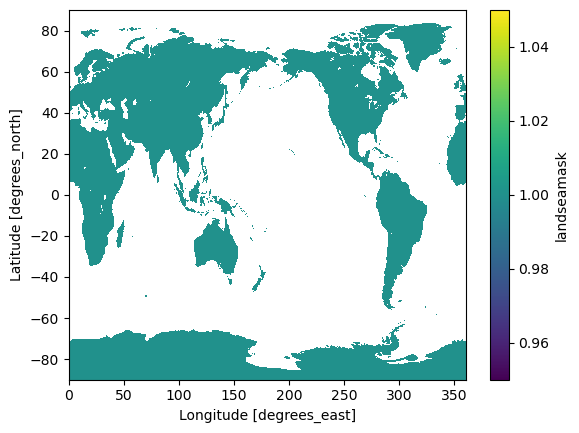

In [61]:
#mask.plot()

In [16]:
# ========== Apply sftlf mask on each model and var =========
for model, variables in ds_dict.items():
    landmask = ds_dict_sftlf[model]
    for var_name, ds in variables.items():
        # Check if dimensions match
        if not (ds.lat.equals(landmask.lat) and ds.lon.equals(landmask.lon)):
            # Interpolate the landmask to match the dataset's lat values
            landmask_interp = landmask.interp(lat=ds.lat, lon=ds.lon, method='linear')
        else:
            landmask_interp = landmask

        # Normalize sftlf to a range of 0 to 1
        sftlf_normalized = landmask_interp.sftlf / 100

        # Multiply the field by normalized sftlf and mask the points where sftlf is 0 (ocean)
        masked_ds = ds.where(sftlf_normalized > 0) # 0.0001 für CESM2-WACCM-FV2
        masked_ds.attrs = ds.attrs

        # Add comment about changes to data
        if 'log' in masked_ds.attrs:
            log_old = masked_ds.attrs['log']
            masked_ds.attrs['log'] = f'Sftlf mask applied. // {log_old}'
        else:
            masked_ds.attrs['log'] = 'Sftlf mask applied.'

        for var in ds.variables:
            masked_ds[var].attrs = ds[var].attrs

        ds_dict[model][var_name] = masked_ds

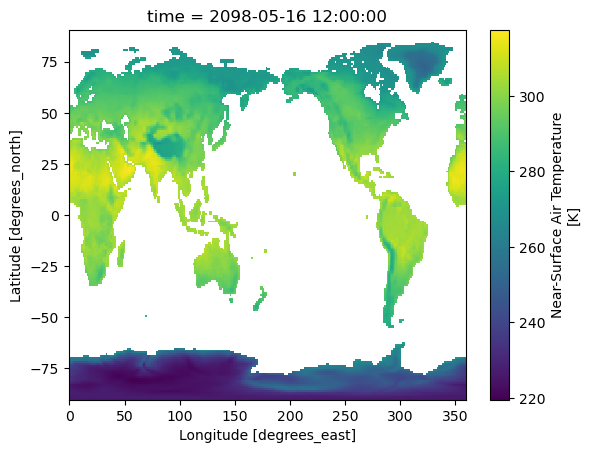

In [13]:
ds_dict[list(ds_dict.keys())[0]]['tas'].isel(time=1000).tas.plot()

### 4. Save and replace netcdf files

In [17]:
# =========== Store file and remove any former one ==========

for model, ds_variables in ds_dict.items():
    for var, ds_var in ds_variables.items():
        folder = 'preprocessed'
        nc_out = save_file({model: ds_var}, variable=var, folder=folder)

File  with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.TaiESM1.historical.tas.nc removed
File with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.TaiESM1.historical.tas.nc saved
File  with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.BCC-CSM2-MR.historical.tas.nc removed
File with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.BCC-CSM2-MR.historical.tas.nc saved
File  with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CanESM5.historical.tas.nc removed
File with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CanESM5.historical.tas.nc saved
File  with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CNRM-CM6-1.historical.tas.nc removed
File with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CNRM-CM6-1.historical.tas.nc saved
File  with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CNRM-ESM2-1.historical.tas.nc removed
File with path: ../../data/CMIP6/historical/preprocessed/tas/CMIP.CNRM-ESM2-1.histori

In [ ]:
# =========== Check stored file ==============
xr.open_dataset(nc_out)